### Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import tensorflow as tf
from tensorflow.python.util.tf_export import keras_export
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Attention
from tensorflow.keras.layers import GRU,Dense,Input,TimeDistributed,RepeatVector
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler

from IPython.display import Image

from timeseries_preprocessing import *
from tensorflow.keras.layers import TimeDistributed
#from specnorm import *

### Data import and preprocessing

In [2]:
#Get Data
df1 = pd.read_csv("Data/household_power_consumption.txt",delimiter=";")

#Format Data
df1["datetime"] = df1[["Date","Time"]].apply(lambda x: x[0]+" "+x[1],axis=1)
df1["datetime"] = pd.to_datetime(df1["datetime"], infer_datetime_format=True)
df1 = df1.drop(["Date","Time"],axis=1)
df1.index = df1["datetime"]
df1 = df1.drop("datetime",axis=1)
df1 = df1.apply(lambda x: pd.to_numeric(x, errors='coerce'))

#Preprocess Data
#Fill NaN values in a smart way
df1 = df1.interpolate()
#resample
df2 = df1.resample('30T').mean()
df2 = df2.interpolate()
#numpy array of values per column
df2_data = df2.values
#Scale values (x-min/max-min)
scaler = MinMaxScaler()
#Alternative: fit_transform(df2_data)
#fit: Compute the minimum and maximum to be used for later scaling.
scaler.fit(df2_data)
#transform: Scale features of X according to feature_range.
df2_data = scaler.transform(df2_data)

for i,name in enumerate(df2.columns):
    df2[name] = df2_data[:,i]

df2.head()

C:\Users\rs1044\AppData\Local\Temp\ipykernel_19504\4254567175.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("Data/household_power_consumption.txt",delimiter=";")


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,0.577718,0.613331,0.326483,0.579554,0.0,0.021918,0.677366
2006-12-16 17:30:00,0.521563,0.225564,0.338921,0.522275,0.0,0.006027,0.678707
2006-12-16 18:00:00,0.495215,0.107544,0.357066,0.498011,0.0,0.187397,0.682731
2006-12-16 18:30:00,0.414938,0.095294,0.311864,0.416468,0.0,0.033425,0.674683
2006-12-16 19:00:00,0.433530,0.063107,0.303577,0.431782,0.0,0.030137,0.674683


### Hyperparameter

In [4]:
#24 historical samples will predict the future samples
sample_length = 24

epochs=20

batch_size = 256
num_encoder_layers = 4
num_decoder_layers = 4
d_model = 32
dff = 512
num_heads = 8
dropout_rate=0.1

"""
sample_length: [day, week, month]
epochs [200]
batch size: 32, 64, 256, 1024, 2048]

encoder_layers [1,2,3,4,5,6]
decoder_layers [1,2,3,4,5,6]
d_model [32, 64, 128, 256]
dff [512]
num_heads [8]
dropout_rate [0.1]

{
  "per_gpu_batch_size": [16, 32],
  "learning_rate": [2e-5, 3e-5, 5e-5],
  "num_epochs": [2, 3, 4]
}
"""

'\nsample_length: [day, week, month]\nepochs [200]\nbatch size: 32, 64, 256, 1024, 2048]\n\nencoder_layers [1,2,3,4,5,6]\ndecoder_layers [1,2,3,4,5,6]\nd_model [32, 64, 128, 256]\ndff [512]\nnum_heads [8]\ndropout_rate [0.1]\n\n{\n  "per_gpu_batch_size": [16, 32],\n  "learning_rate": [2e-5, 3e-5, 5e-5],\n  "num_epochs": [2, 3, 4]\n}\n'

### Train and Test Data

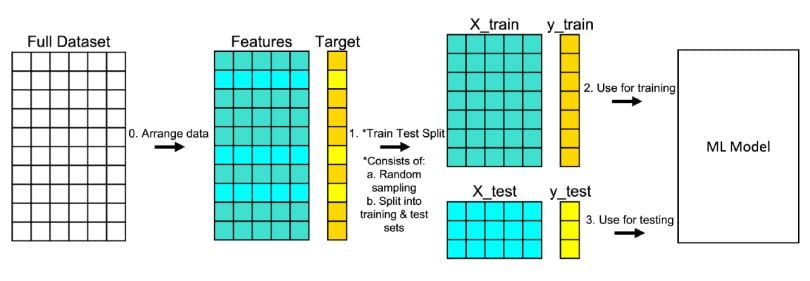

In [5]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename= "img/train-test-split.jpg")

In [6]:
"""
Split arrays or matrices into random train and test subsets.
-> From the features in array 1 we predict the columns of array2
array1: df2.iloc[:,:-3] (Global active power, Voltage, Global reactive power, global intensity)
array2: df2.iloc[:,-3:] (Submetering 1-3)
test_size: proportion of the dataset to include in the test split (often 0.30)
shuffle: False -> preserve the sequential information (True -> scramble rows and destroy temporal information)
"""
#Features: X_train and X_test are used to forecast target: y_train and y_test
X_train, X_test, y_train, y_test = train_test_split(df2.iloc[:,:-3].values, df2.iloc[:,-3:].values, test_size=0.05,shuffle=False)
# Casts a tensor to a new type.
data = tf.cast(X_train,tf.float32)
targets = tf.cast(y_train,tf.float32)

#Creates a dataset of sliding windows over a timeseries provided as array.
"""
data: Numpy array or tensor containing consecutive data points. Axis 0 is expected to be the time dimension.
targets: Targets corresponding to timesteps in data. Pass None if you don't have target data.
sequence_length: Length of the output sequences (in number of timesteps).
sequence_stride: Period between successive output sequences. For stride s, 
    output samples would start at index data[i], data[i + s], data[i + 2 * s], etc
sampling_rate: eriod between successive individual timesteps within sequences. For rate r, 
    timesteps data[i], data[i + r], ... data[i + sequence_length] are used for creating a sample sequence.
batch_size: Number of timeseries samples in each batch (except maybe the last one). If None, 
    the data will not be batched (the dataset will yield individual samples).
"""
#24 historical samples (sample_length) of the first 4 columns (data/ features) 
#will predict the future 6 samples (output_seqeunce_length) of the last 3 columns (target)
input_dataset = timeseries_dataset_from_array(
    data,
    None, 
    sequence_length=sample_length,
    batch_size=batch_size, 
    sequence_stride=sample_length
)
target_dataset = timeseries_dataset_from_array(
    targets, 
    None, 
    sequence_length=6,
    batch_size=batch_size, 
    sequence_stride=sample_length
)

### Building the Transformer Model

In [8]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

@tf.function
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)


def create_masks(inp, tar):
  # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask

@tf.function  
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    # dk = k.get_shape().as_list()[-1]
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads,spec_norm=False):
        super(MultiHeadAttention, self).__init__()
        self.kernel_init = tf.keras.initializers.Orthogonal()
        self.num_heads = num_heads
        self.d_model = d_model
        if spec_norm:
            self.spec_norm = SpectralNormalization
        else:
            self.spec_norm = lambda x: x

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = self.spec_norm(tf.keras.layers.Dense(d_model,kernel_initializer=self.kernel_init))
        self.wk = self.spec_norm(tf.keras.layers.Dense(d_model,kernel_initializer=self.kernel_init))
        self.wv = self.spec_norm(tf.keras.layers.Dense(d_model,kernel_initializer=self.kernel_init))

        self.dense = self.spec_norm(tf.keras.layers.Dense(d_model,kernel_initializer=self.kernel_init))
        # self.attn_layer = Attention(use_scale=True)
        
    @tf.function   
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention= scaled_dot_product_attention(q, k, v, mask)
        # scaled_attention = self.attn_layer([q,v,k],[mask,None])
        # attention_weights = None

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output
    
def point_wise_feed_forward_network(d_model, dff,spec_norm=False):
    if spec_norm:
        wrapper = SpectralNormalization
    else:
        wrapper = lambda x: x
    kernel_init = tf.keras.initializers.Orthogonal()
    return tf.keras.Sequential([
      wrapper(tf.keras.layers.Dense(dff, activation='relu',kernel_initializer=kernel_init)),  # (batch_size, seq_len, dff)
      wrapper(tf.keras.layers.Dense(d_model,kernel_initializer=kernel_init))  # (batch_size, seq_len, d_model)
    ])

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1,spec_norm=False):
        super(EncoderLayer, self).__init__()
        self.spec_norm = spec_norm
        self.mha = MultiHeadAttention(d_model, num_heads,self.spec_norm)
        self.ffn = point_wise_feed_forward_network(d_model, dff,self.spec_norm)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
         
    def call(self, x, training, mask):

        attn_output = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        attn1= self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2 = self.mha2(enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3
    

class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1,spec_norm=False):
        super(Encoder, self).__init__()
        
        if spec_norm:
            self.spec_norm = SpectralNormalization
        else:
            self.spec_norm = lambda x: x


        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = TimeDistributed(self.spec_norm(tf.keras.layers.Dense(d_model,kernel_initializer = tf.keras.initializers.Orthogonal())))
        
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate,spec_norm) for _ in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        
    def build(self, input_shape):
        self.n_timesteps = input_shape.as_list()[1]
        self.pos_encoding = positional_encoding(self.n_timesteps, self.d_model)
           
    def transform(self,x):
        seq_len = x.get_shape().as_list()[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        # x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x * np.sqrt(self.d_model)
        x = x + self.pos_encoding[:, :seq_len, :]
        return x

    def call(self, x, training, mask):

        # seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        # x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        # x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        # x = x * np.sqrt(self.d_model)
        # x = x + self.pos_encoding[:, :seq_len, :]
        x = self.transform(x)
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = TimeDistributed(tf.keras.layers.Dense(d_model,kernel_initializer = tf.keras.initializers.Orthogonal()))

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
    def build(self, input_shape):
        self.n_timesteps = input_shape.as_list()[1]
        self.pos_encoding = positional_encoding(self.n_timesteps, self.d_model)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, training,
                                                 look_ahead_mask, padding_mask)

            # attention_weights[f'decoder_layer{i+1}_block1'] = block1
            # attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x
    
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    # return tf.cast(pos_encoding, dtype=tf.float32)
    return pos_encoding



class Transformer(tf.keras.Model):
    #Initilaize Transformer and set class variables
    """
    n_target_features: number of features to predict
    num_layers: number of layers 
    d_model: dimensionality of the representations used as input to the multi-head attention, 
    num_heads: number of attentio heads, 
    dff: internal dimensionality of the FeedForward layer, 
    rate: Dropout rate
    """
    def __init__(self,
                 n_target_features, 
                 num_encoder_layers=4, 
                 num_decoder_layers=4,
                 d_model=128, 
                 num_heads=8, 
                 dff=512, 
                 rate=dropout_rate,
                ):
        super(Transformer, self).__init__()
        #number of predicted values
        self.n_target_features = n_target_features
        #Initilaize Encoder
        self.tokenizer = Encoder(
            num_encoder_layers, 
            d_model, 
            num_heads, 
            dff, 
            rate
        )
        #Initiliaze Decoder
        self.decoder = Decoder(
            num_decoder_layers, 
            d_model, 
            num_heads, 
            dff, 
            rate
        )
        #Dense layers to project the input vectors before using them.
        self.final_layer = tf.keras.layers.Dense(self.n_target_features)
    
    """
    inp: batch_size
    tar: batch_size
    training: inp_seq_len
    """
    def call(self, inp, tar, training):

        look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
        
        enc_output = self.tokenizer(inp, training, None)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output = self.decoder(tar, enc_output, training, look_ahead_mask, None)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output

### Setup Transformer

In [10]:
xformer = Transformer(
    n_target_features=3,
    num_encoder_layers = num_encoder_layers, 
    num_decoder_layers = num_decoder_layers,
    num_heads=num_heads,
    dff=dff,
    d_model=d_model, 
    rate=dropout_rate
)
pred = xformer(
    inp=tf.random.normal((1,24,4)),
    tar=tf.random.normal((1,6,3)),
    training=False
)
# xformer.load_weights("xformer.h5")
#print(pred.shape)
#xformer.summary()

C:\Users\rs1044\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer Orthogonal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


### Set Up GRU

In [11]:
in1 = Input((24,4))
gru1 = GRU(128)(in1)
gru2 = RepeatVector(6)(gru1)
gru2 = GRU(128,return_sequences=True)(gru2)
gru2 = TimeDistributed(Dense(3))(gru2)

model = Model(in1,gru2)
#model.summary()

### Training

In [12]:
#Optimizer


# Use the Adam optimizer with a custom learning rate scheduler according to the formula in the original Transformer paper.
#lrate = d_model^-0.5 * min(step_num^-0.5, step_num*warmup_steps^-1.5)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
learning_rate = CustomSchedule(d_model)

#Adam optimization is a stochastic gradient descent method that is based on 
#adaptive estimation of first-order and second-order moments.
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,epsilon=1e-9)

#learning_rate: Defaults to 0.001
optimizer2 = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98,epsilon=1e-9)

In [13]:
len_data = sum(1 for _ in input_dataset)
#For each Epoch
for e in range(epochs):
    #For every batch in the data_batch
    for i,batch in enumerate(zip(input_dataset, target_dataset)):
        #if not last batch
        if i<len_data-1:
            #take the ith input and darget batch
            in1, tar = batch
            
            #Create a tensor with all elements set to one in dimension 256, 1, 3 and scale it with -0.1
            tar_inp = tf.ones((256,1,3))*-0.1
            tar_inp = tf.concat([tar_inp,tar[:, :-1]],axis=1)
            tar_real = tar[:, 1:]
            """
            #Computes the gradient using operations recorded in context of this tape.
            #Example
            with tf.GradientTape() as t1:
                loss1_result= loss1(true, pred)
            grads1 = t1.gradient(loss1_result, var_list1)
            """
            with tf.GradientTape() as tape:
                #Make predictions with input batch (in1), output
                predictions = xformer(in1, tar_inp,True)
                #Calculate Mean Squared Error (MSE)
                loss = tf.reduce_mean(tf.square(tar_real-predictions[:,:-1]))
            """
            #Calculate gradient using loss as function and trainable_variables as input
            x = tf.ragged.constant([[1.0, 2.0], [3.0]])
            with tf.GradientTape() as g:
              g.watch(x)
              y = x * x
            g.gradient(y, x)
            [[2.0, 4.0], [6.0]]
            """
            gradients = tape.gradient(loss, xformer.trainable_variables)
            #Apply optimizer
            optimizer.apply_gradients(zip(gradients, xformer.trainable_variables))
            
            """
            #Same for GRU
            with tf.GradientTape() as tape:
                pred2 = model(in1)
                loss2 = tf.reduce_mean(tf.square(tar-pred2))
            gradients = tape.gradient(loss2, model.trainable_variables)
            optimizer2.apply_gradients(zip(gradients, model.trainable_variables))
            """

    
    print(f"epoch {e}| Transformer:{loss.numpy()}")
    #print(f"epoch {e}| Transformer:{loss.numpy()} | GRU:{loss2.numpy()}")

epoch 0| Transformer:3.875502586364746
epoch 1| Transformer:2.758338451385498
epoch 2| Transformer:1.418770670890808
epoch 3| Transformer:0.5570831298828125
epoch 4| Transformer:0.6359307765960693
epoch 5| Transformer:0.4600798785686493
epoch 6| Transformer:0.4254978895187378
epoch 7| Transformer:0.38603463768959045
epoch 8| Transformer:0.3219052851200104
epoch 9| Transformer:0.28768131136894226
epoch 10| Transformer:0.26121705770492554
epoch 11| Transformer:0.24930308759212494
epoch 12| Transformer:0.22067829966545105
epoch 13| Transformer:0.2096727341413498
epoch 14| Transformer:0.18230366706848145
epoch 15| Transformer:0.16613611578941345
epoch 16| Transformer:0.16186116635799408
epoch 17| Transformer:0.1484900861978531
epoch 18| Transformer:0.13627570867538452
epoch 19| Transformer:0.1291346698999405


In [14]:
def predict(inp):
    
    inp = inp.reshape(-1,24,4)
#     inp = tf.reshape(inp,(-1,24,4))
    n_batch = inp.shape[0]
    start = np.ones((n_batch,1,3))*-0.1
    
    for i in range(6):
        
        pred = xformer(inp,start,False)
        pred = np.expand_dims(pred[:,-1,:],0)
        start = np.concatenate([start,pred],axis=1)
#         print(start.shape)
        
    return start[:,1:]

In [15]:
x_test = timeseries_dataset_from_array(X_test,None, sequence_length=sample_length,batch_size=1, sequence_stride=sample_length)
y_test = timeseries_dataset_from_array(y_test, None, sequence_length=6,batch_size=1, sequence_stride=sample_length)
x_test = list(x_test.as_numpy_iterator())
y_test = list(y_test.as_numpy_iterator())

In [16]:
x_test2 = np.asarray(x_test).reshape(-1,24,4)
y_test2 = np.asarray(y_test).reshape(-1,6,3)

In [17]:
preds_xform = [predict(x) for x in x_test2]

In [18]:
err_xform = np.mean([(y_true-y_pred)**2 for y_true,y_pred in zip(y_test2,preds_xform)])

pred_gru = model(x_test2)
err_gru = np.mean((pred_gru-y_test2)**2)

err_xform,err_gru

(0.04158305031998204, 0.094803944)